In [1]:
!pip install wordcloud

In [2]:
!pip show wordcloud


Name: wordcloud
Version: 1.9.4
Summary: A little word cloud generator
Home-page: https://github.com/amueller/word_cloud
Author: 
Author-email: Andreas Mueller <t3kcit+wordcloud@gmail.com>
License: MIT License
Location: C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages
Requires: matplotlib, numpy, pillow
Required-by: 


In [3]:
import sys
!{sys.executable} -m pip install wordcloud



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None
label
1    10413
0    10387
Name: count, dtype: int64
id           0
title      558
author    1957
text        39
label        0
dtype: int64
       word_count
label            
0      867.612978
1      672.978362
📘 Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      2052
           1       0.95      0.95      0.95      1911

    accuracy                           0.95      3963
   macro avg       0.95      0.95      0.95      3963
weighted avg       0.95      0.95      0.95      3963

🌲 Random Forest:
 

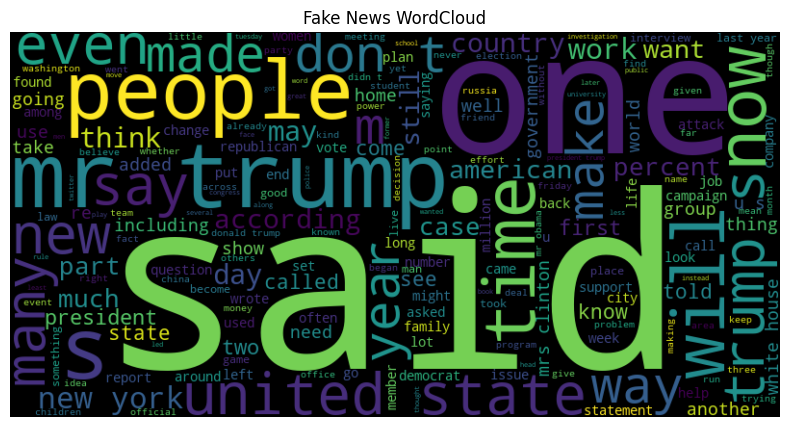

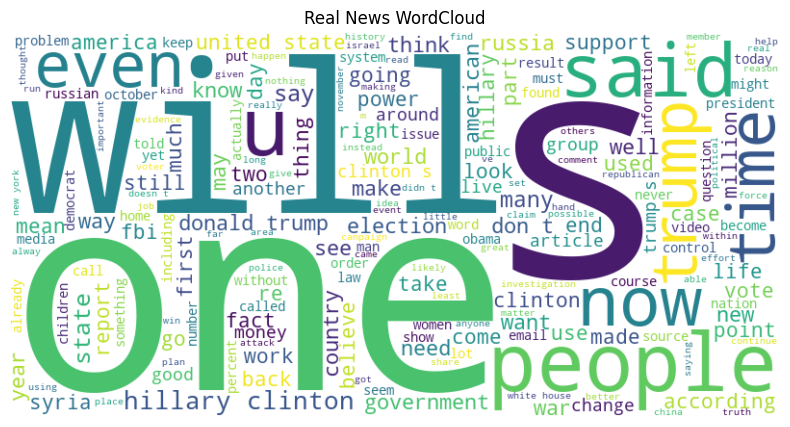

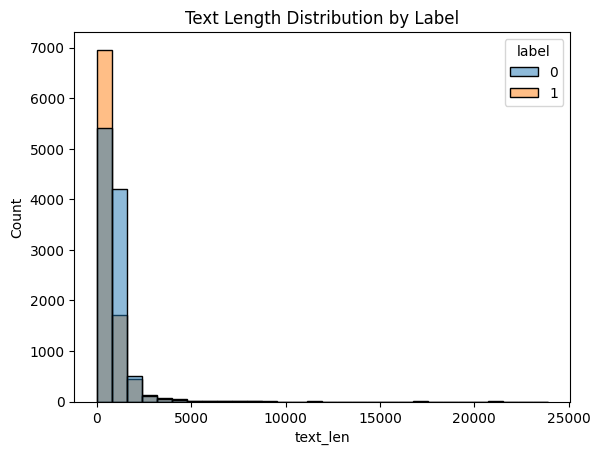

In [ ]:
# ✅ SECTION 1: Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pickle

# ✅ SECTION 2: Load and Preview Data
df = pd.read_csv("fake_news.csv")

print(df.info())
print(df['label'].value_counts())  # 0 = fake, 1 = real
print(df.isnull().sum())

# Drop nulls in important fields
df.dropna(subset=['title', 'text'], inplace=True)

# ✅ SECTION 3: Clean Text & Features
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['title_clean'] = df['title'].apply(clean_text)

# Drop duplicates
df = df.drop_duplicates(subset=['clean_text'])
df = df.dropna(subset=['clean_text'])

# ✅ SECTION 4: Feature Engineering
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
print(df[['word_count', 'label']].groupby('label').mean())

# ✅ SECTION 5: TF-IDF Vectorization
X = df['clean_text']
y = df['label']  # 0 = fake, 1 = real

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# ✅ SECTION 6: Train Models
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
print("📘 Logistic Regression:\n", classification_report(y_test, lr_pred))

rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
print("🌲 Random Forest:\n", classification_report(y_test, rf_pred))

svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
print("📗 SVM:\n", classification_report(y_test, svm_pred))

# Accuracy Summary
print("✅ Accuracy Summary:")
print(f"Logistic Regression: {accuracy_score(y_test, lr_pred):.4f}")
print(f"Random Forest:       {accuracy_score(y_test, rf_pred):.4f}")
print(f"SVM:                 {accuracy_score(y_test, svm_pred):.4f}")

# ✅ SECTION 7: Choose Best Model
best_model = lr_model  # You can change this

# ✅ SECTION 8: Hyperparameter Tuning (Optional)
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_tfidf, y_train)
print("🔍 Best Params (LogisticRegression):", grid.best_params_)

# ✅ SECTION 9: Save Model and Vectorizer
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# ✅ SECTION 10: EDA - WordClouds
fake_text = ' '.join(df[df['label'] == 0]['clean_text'])
real_text = ' '.join(df[df['label'] == 1]['clean_text'])

wc_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News WordCloud")
plt.show()

wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("Real News WordCloud")
plt.show()

# ✅ SECTION 11: Text Length Distribution
df['text_len'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='text_len', hue='label', bins=30)
plt.title("Text Length Distribution by Label")
plt.show()
